In [1]:
!pip install numpy seaborn Jinja2

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
from scipy import stats

sns.set_theme()

yash_ip = "10.104.168.213" # I (Yash) logged in

START_DATE = datetime.datetime(2024, 4, 23)

TIME_COL = "Time"
IP_COL = "IP"
DATE_COL = "Date"
HOUR_COL = "Hour"

In [3]:
def counts_to_df(counts):
    """Turn value_counts into a DataFrame"""
    return counts.reset_index(level=0).rename({"count": "Count"}, axis=1)

In [4]:
def unique_ips(df: pd.DataFrame, by: str):
    """Get the number of unique IPs, grouping by the column `by`"""
    return df.groupby(by).apply(
        lambda df: df[IP_COL].drop_duplicates().count(), include_groups=False
    )

# SSH stuff

In [5]:
def filter_date(df: pd.DataFrame):
    return df[df[TIME_COL].map(lambda dt: START_DATE < dt)]


def setup_df(df: pd.DataFrame):
    # Remove the rows where I logged in

    # Sort by time
    df = df[df[IP_COL] != yash_ip]
    df = df.sort_values(by=TIME_COL)
    df = df.reset_index(drop=True)

    # Add Date column
    df = df.copy()
    df[DATE_COL] = df[TIME_COL].map(lambda dt: dt.strftime("%m/%d"))
    df[HOUR_COL] = df[TIME_COL].map(lambda dt: dt.hour)

    return df

In [6]:
logins = pd.read_csv(
    "data/ssh/logins.txt", sep=";", names=[TIME_COL, IP_COL, "Session"], parse_dates=["Time"]
)
logins = filter_date(logins)
logins = setup_df(logins)
logins

,Time,IP,Session,Date,Hour
0,2024-04-23 00:57:18.914,179.43.180.108,f64c0cf0-012d-11ef-89d9-ef9c1dc5e411,04/23,0
1,2024-04-23 01:40:00.551,183.81.169.238,ed272460-0133-11ef-89d9-ef9c1dc5e411,04/23,1
2,2024-04-23 02:09:06.618,42.203.111.50,fde3d290-0137-11ef-89d9-ef9c1dc5e411,04/23,2
3,2024-04-23 03:12:19.503,183.81.169.238,d2a024e0-0140-11ef-89d9-ef9c1dc5e411,04/23,3
4,2024-04-23 05:28:38.390,170.64.214.38,dd9d4680-0153-11ef-8e48-bbd0010f6974,04/23,5
...,...,...,...,...,...
92,2024-04-30 14:18:13.680,161.35.185.20,020fd4e0-071e-11ef-abf8-05d8cbeee375,04/30,14
93,2024-04-30 14:22:44.881,161.35.185.20,a3b5f900-071e-11ef-abf8-05d8cbeee375,04/30,14
94,2024-04-30 14:27:17.447,161.35.185.20,462c3e60-071f-11ef-abf8-05d8cbeee375,04/30,14
95,2024-04-30 14:31:51.941,161.35.185.20,e9c8b440-071f-11ef-abf8-05d8cbeee375,04/30,14


In [7]:
login_attempts = pd.read_csv(
    "data/ssh/login_attempts.txt",
    sep=";",
    names=[TIME_COL, IP_COL, "method", "Name", "Password"],
    parse_dates=["Time"],
    # MITM doesn't wrap passwords with semicolons in them in quotes
    on_bad_lines=lambda lines: (
        lines[:-2] + [";".join(lines[-2:])] if len(lines) == 6 else lines
    ),
    engine="python",
)

login_attempts.drop("method", axis=1, inplace=True)

login_attempts["Name"] = login_attempts["Name"].apply(str)
login_attempts["Password"] = login_attempts["Password"].apply(str)

login_attempts = filter_date(login_attempts)
login_attempts = setup_df(login_attempts)

login_attempts

,Time,IP,Name,Password,Date,Hour
0,2024-04-23 00:01:12.087,220.179.241.68,root,power,04/23,0
1,2024-04-23 00:04:50.123,60.222.242.9,user,user2021,04/23,0
2,2024-04-23 00:11:32.759,183.81.169.238,root,0,04/23,0
3,2024-04-23 00:11:36.123,183.81.169.238,root,eve,04/23,0
4,2024-04-23 00:11:39.693,183.81.169.238,root,root,04/23,0
...,...,...,...,...,...,...
22866,2024-04-30 17:11:08.727,161.35.185.20,fahdp,fahdp,04/30,17
22867,2024-04-30 17:14:13.324,159.89.24.153,asrahma1,asrahma1,04/30,17
22868,2024-04-30 17:14:18.022,170.64.188.83,dev,dev,04/30,17
22869,2024-04-30 17:15:44.574,161.35.185.20,fanglanc,fanglanc,04/30,17


In [8]:
login_attempts["IP"].value_counts().nlargest(15)

IP
192.3.12.163      9501
180.97.220.14     1395
183.81.169.238     946
68.183.155.250     718
58.251.255.204     715
179.43.180.108     701
146.190.99.162     622
158.69.39.171      551
170.64.214.38      476
170.64.166.132     476
170.64.156.125     465
134.209.0.27       412
116.55.248.235     411
138.197.147.2      325
92.118.39.245      319
Name: count, dtype: int64

In [146]:
names = counts_to_df(login_attempts["Name"].value_counts())
names.nlargest(20, columns=["Count"])

,Name,Count
0,root,14810
1,admin,1002
2,user,514
3,ubuntu,370
4,debian,301
5,test,222
6,oracle,202
7,support,129
8,ftpuser,99
9,postgres,89


In [10]:
f'{names[names["Name"] == "root"]["Count"].iloc[0] / names["Count"].sum() * 100}% of login attempts used root as the username'

'81.78705544510714% of login attempts used root as the username'

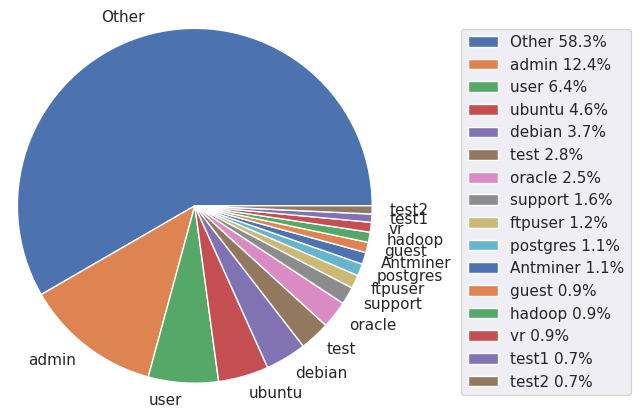

In [147]:
names_pie = names.copy()
names_pie = names_pie[names_pie["Name"] != "root"]
names_pie.loc[
    names_pie["Count"].apply(lambda n: n < 60 if isinstance(n, int) else False),
    "Name",
] = "Other"
names_pie = names_pie.groupby("Name")["Count"].sum().sort_values(ascending=False)
total = names_pie.sum()
percents = names_pie.apply(lambda count: (count / total) * 100)
plt.pie(names_pie, labels=names_pie.index, radius=1.2)
plt.legend(
    labels=[
        f"{name} {percent:0.1f}%" for name, percent in zip(names_pie.index, percents)
    ],
    loc="upper right",
    bbox_to_anchor=(1.7, 1),
)
None

In [148]:
counts_to_df(login_attempts["Password"].value_counts().nlargest(20))

,Password,Count
0,123456,678
1,root,318
2,123,315
3,admin,307
4,1234,215
5,1,213
6,test,170
7,password,166
8,12345,162
9,12345678,158


In [149]:
names_passes = counts_to_df(
    (
        login_attempts["Name"].map(lambda n: n + " / ") + login_attempts["Password"]
    ).value_counts()
).rename({"index": "Username / Password"}, axis=1)
names_passes.head(20)

,Username / Password,Count
0,root / root,159
1,root / admin,134
2,root / 123456,128
3,root / 1,123
4,root / 123,123
5,root / 0,119
6,root / eve,112
7,root / 123123,99
8,admin / admin1,92
9,root / 12345,78


<Figure size 1200x1200 with 0 Axes>

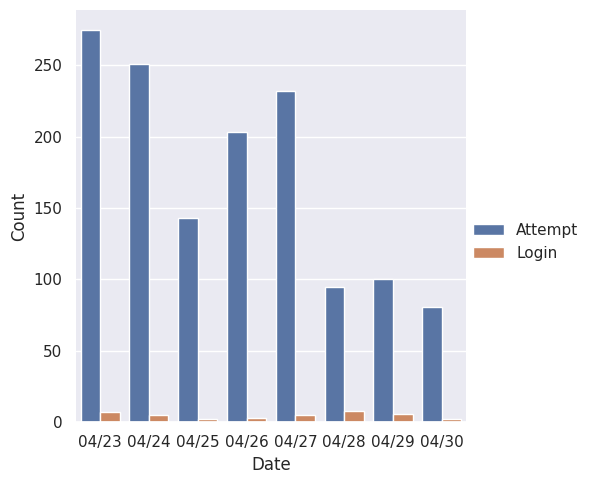

In [14]:
# Number of logins and login attempts each day (uniqued by IP)
both_uniq_by_day = pd.concat(
    [
        pd.DataFrame(
            {
                "Count": unique_ips(login_attempts, DATE_COL),
                "Type": "Attempt",
            }
        ),
        pd.DataFrame(
            {
                "Count": unique_ips(logins, DATE_COL),
                "Type": "Login",
            }
        ),
    ]
)

plt.figure(figsize=(12, 12))
g = sns.catplot(data=both_uniq_by_day, kind="bar", x="Date", y="Count", hue="Type")
g.despine(left=True)
g.legend.set_title("")

## Patience

How many login attempts was an attacker willing to make before giving up?

In [60]:
from itertools import groupby

num_attempts = []
# Based on https://stackoverflow.com/a/32684633/11882002
for ip, group in groupby(login_attempts.iterrows(), key=lambda row: row[1][IP_COL]):
    num_attempts.append([ip, len(list(group))])

num_attempts = pd.DataFrame(num_attempts, columns=[IP_COL, "Num attempts"])
num_attempts.describe()

,Num attempts
count,5084.000000
mean,4.498623
std,31.076935
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,933.000000


In [89]:
counts_to_df(
    num_attempts.groupby(IP_COL).max().nlargest(5, columns="Num attempts")
).rename({"Num attempts": "Max attempts"}, axis=1)

,IP,Max attempts
0,192.3.12.163,933
1,134.209.0.27,303
2,170.64.214.38,172
3,58.251.255.204,160
4,116.55.248.235,143


/tmp/ipykernel_3710/3974137447.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '>= 64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  counts.loc[counts["Num attempts"] >= 64, "Num attempts"] = ">= 64"


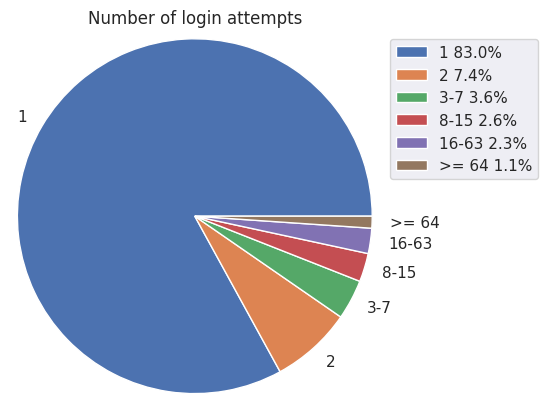

In [142]:
counts = counts_to_df(num_attempts["Num attempts"].value_counts())
counts.loc[counts["Num attempts"] >= 64, "Num attempts"] = ">= 64"
counts.loc[
    counts["Num attempts"].apply(lambda n: n >= 16 if isinstance(n, int) else False),
    "Num attempts",
] = "16-63"
counts.loc[
    counts["Num attempts"].apply(lambda n: n >= 8 if isinstance(n, int) else False),
    "Num attempts",
] = "8-15"
counts.loc[
    counts["Num attempts"].apply(lambda n: n >= 3 if isinstance(n, int) else False),
    "Num attempts",
] = "3-7"
counts = counts.groupby("Num attempts")["Count"].sum().sort_values(ascending=False)
total = counts.sum()
percents = counts.apply(lambda count: (count / total) * 100)
plt.pie(counts, labels=counts.index, radius=1.2)
plt.legend(
    labels=[f"{name} {percent:0.1f}%" for name, percent in zip(counts.index, percents)],
    loc="upper right",
    bbox_to_anchor=(1.45, 1),
)
plt.title("Number of login attempts")
None

## Session duration

<Axes: title={'center': 'Session durations'}, xlabel='Minutes', ylabel='Count'>

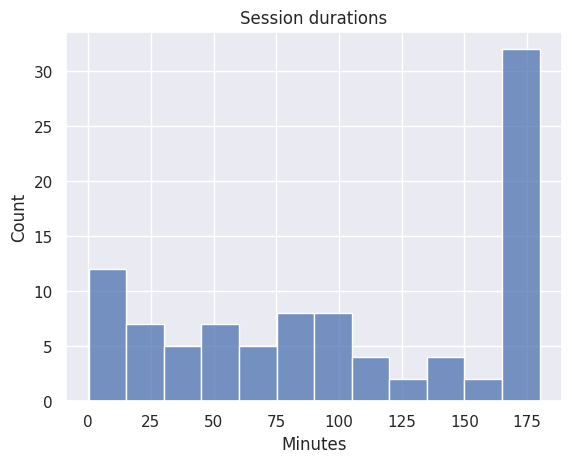

In [124]:
MAX_TIME = datetime.timedelta(hours=3)

times = logins[TIME_COL]
durations = times - times.shift(1)
durations = durations.iloc[1:]  # Drop NaT
durations = durations.apply(lambda dur: min(dur, MAX_TIME))  # Cap at lifecycle length
minutes = durations.apply(lambda dur: dur.seconds / 60).rename("Minutes")

plt.title("Session durations")
sns.histplot(minutes, binwidth=15)

In [127]:
31/len(minutes)

0.3229166666666667

# Web stuff

In [15]:
import re

COUNT_COL = "Count"
PATH_COL = "Path"

with open("data/web/request_logs.txt") as web_log_file:
    web_logs = web_log_file.readlines()

matches = []
for line in web_logs:
    m = re.search("^2024-04-(\d\d)T(\d\d).+Z - IP: ::ffff:(.+), Method: (\w+), Path: (.+), Query", line)
    date, hour, ip, method, path = m.groups()
    matches.append([f"04/{date}", int(hour), ip, path])

reqs = pd.DataFrame(matches, columns=[DATE_COL, "Hour", IP_COL, PATH_COL])
reqs

,Date,Hour,IP,Path
0,04/23,2,198.199.101.89,/
1,04/23,3,65.49.1.117,/
2,04/23,3,65.49.1.109,/favicon.ico
3,04/23,5,87.236.176.59,/
4,04/23,7,198.235.24.2,/
...,...,...,...,...
100,04/30,16,147.182.217.243,/favicon.ico
101,04/30,21,206.168.34.117,/
102,04/30,21,206.168.34.117,/favicon.ico
103,04/30,22,206.189.192.104,/


In [16]:
counts_to_df(reqs[PATH_COL].value_counts())

,Path,Count
0,/,62
1,/favicon.ico,19
2,/robots.txt,3
3,/v2/_catalog,3
4,/solr/admin/info/system,3
5,/cgi-bin/authLogin.cgi,3
6,/query,3
7,/solr/admin/cores,3
8,/api/v1/users/search,2
9,/sitemap.xml,2


# Comparing

## Requests/login attempts by day

In [17]:
def by_day_graph(title, data, ax=None):
    if ax is None:
        plt.title(title)
    else:
        ax.set_title(title)
    g = sns.barplot(data=data, ax=ax)
    g.set_xticks(g.get_xticks(), labels=g.get_xticklabels(), rotation=30);

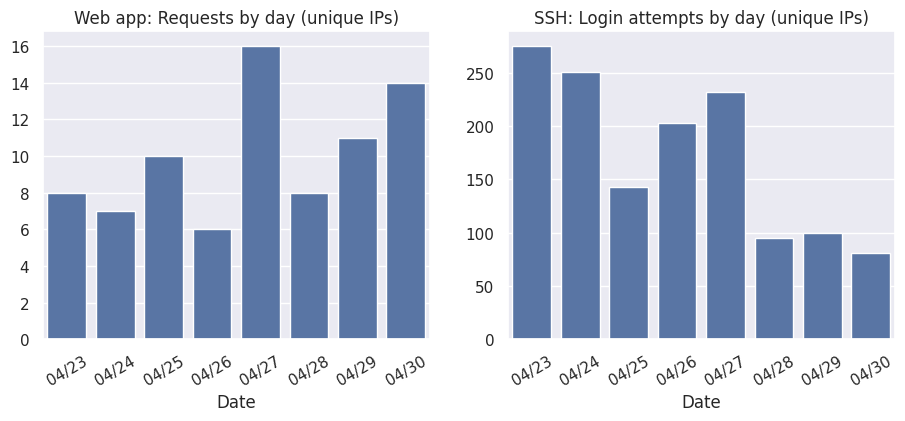

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

by_day_graph(
    "Web app: Requests by day (unique IPs)", unique_ips(reqs, DATE_COL), ax=axes[0]
)
by_day_graph(
    "SSH: Login attempts by day (unique IPs)",
    unique_ips(login_attempts, DATE_COL),
    ax=axes[1],
)

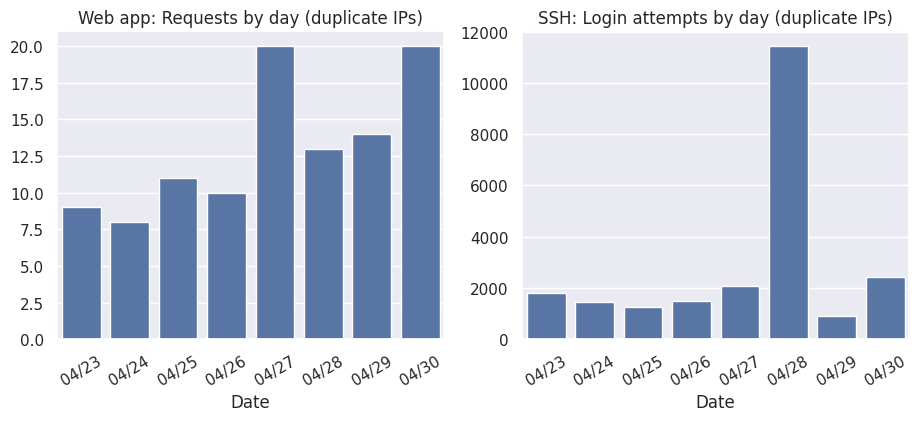

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

by_day_graph(
    "Web app: Requests by day (duplicate IPs)",
    reqs.groupby(DATE_COL).apply(len, include_groups=False),
    ax=axes[0],
)
by_day_graph(
    "SSH: Login attempts by day (duplicate IPs)",
    login_attempts.groupby(DATE_COL).apply(len, include_groups=False),
    ax=axes[1],
)

In [20]:
# Is the mean of the distribution underlying the number of requests per day less than
# the mean of the distribution underlying the number of login attempts per day?
stats.ttest_ind(
    unique_ips(reqs, DATE_COL), unique_ips(login_attempts, DATE_COL), alternative="less"
)

TtestResult(statistic=-5.952825973573484, pvalue=1.7651534112565676e-05, df=14.0)

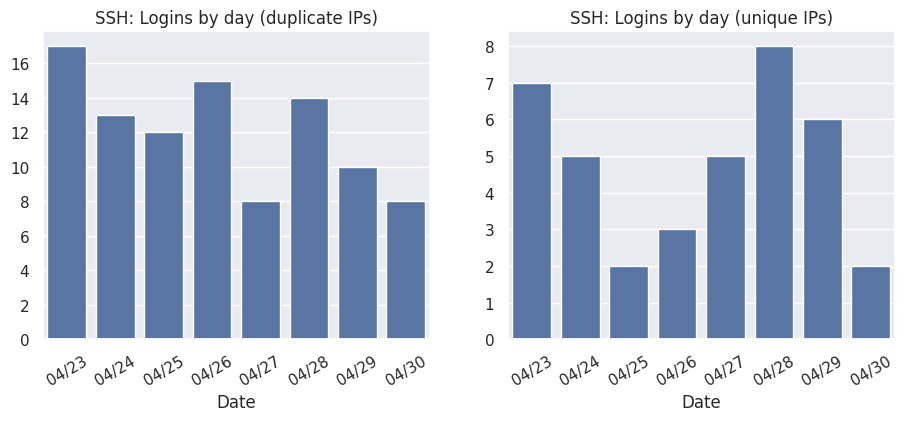

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

by_day_graph(
    "SSH: Logins by day (duplicate IPs)",
    logins.groupby(DATE_COL).apply(len, include_groups=False),
    ax=axes[0],
)
by_day_graph(
    "SSH: Logins by day (unique IPs)",
    unique_ips(logins, DATE_COL),
    ax=axes[1],
)

## Requests/login attempts by hour

In [155]:
def by_hour_graph(title, data):
    plt.figure(figsize=(11, 5))
    plt.title(title)
    g = sns.lineplot(data=data)
    g.set_xticks(ticks=list(range(24)))
    plt.xlim(xmin=-0.5, xmax=23.5)
    plt.xlabel("Hour")

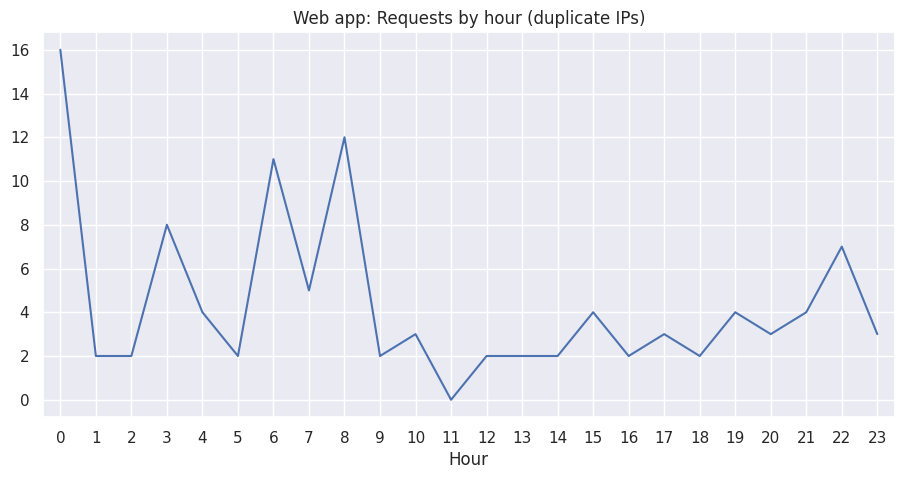

In [156]:
by_hour_graph(
    "Web app: Requests by hour (duplicate IPs)",
    pd.Series([len(reqs[reqs[HOUR_COL] == hour]) for hour in range(24)])
)

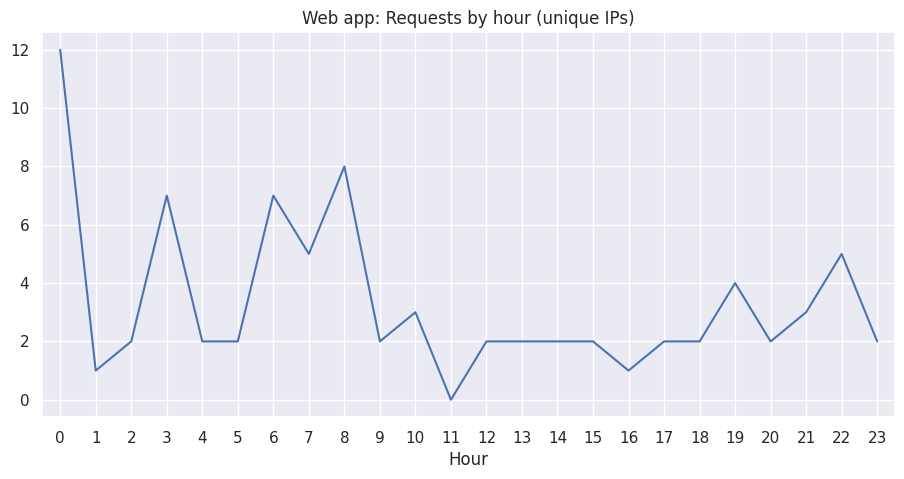

In [167]:
df = unique_ips(reqs, HOUR_COL)
by_hour_graph(
    "Web app: Requests by hour (unique IPs)",
    pd.Series([df.iloc[list(df.index).index(hour)] if hour in df.index else 0 for hour in range(24)]),
)

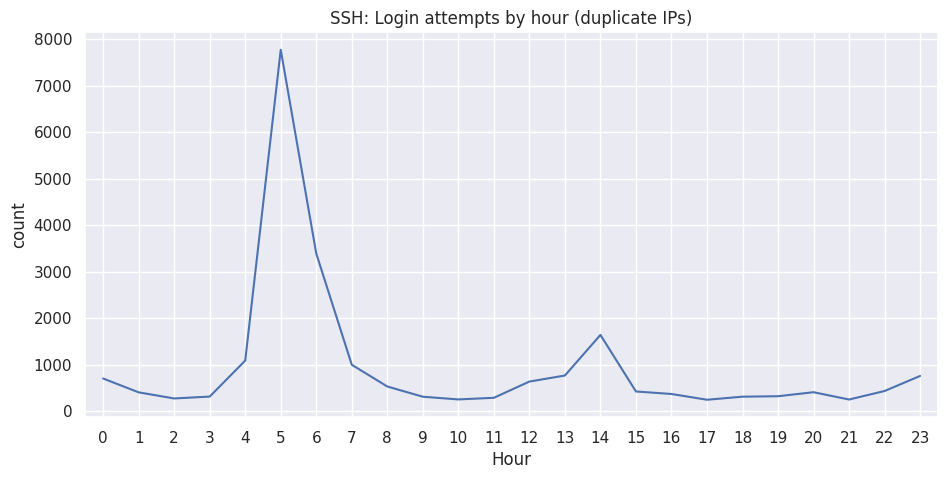

In [25]:
by_hour_graph(
    "SSH: Login attempts by hour (duplicate IPs)",
    login_attempts[HOUR_COL].value_counts(),
)

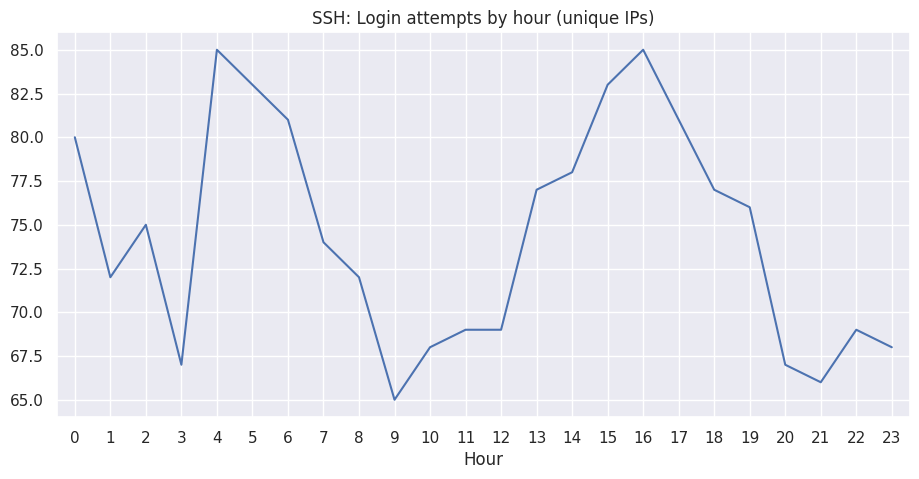

In [26]:
by_hour_graph(
    "SSH: Login attempts by hour (unique IPs)", unique_ips(login_attempts, HOUR_COL)
)

## Repeat attackers

In [27]:
df = counts_to_df(reqs[IP_COL].value_counts().nlargest(10))
df.style.set_caption("Web app requests")

,IP,Count
0,165.154.118.169,4
1,159.203.181.211,4
2,206.189.192.104,4
3,152.32.159.177,4
4,24.144.100.116,3
5,162.142.125.11,2
6,45.128.232.213,2
7,184.105.247.194,2
8,142.93.242.255,2
9,162.142.125.8,2


In [28]:
df = counts_to_df(login_attempts[IP_COL].value_counts().nlargest(10))
df.style.set_caption("SSH login attempts")

,IP,Count
0,192.3.12.163,9501
1,180.97.220.14,1395
2,183.81.169.238,946
3,68.183.155.250,718
4,58.251.255.204,715
5,179.43.180.108,701
6,146.190.99.162,622
7,158.69.39.171,551
8,170.64.214.38,476
9,170.64.166.132,476


In [29]:
reqs[IP_COL].value_counts().describe()

count    76.000000
mean      1.381579
std       0.765369
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
Name: count, dtype: float64

In [30]:
login_attempts[IP_COL].value_counts().describe()

count    1112.000000
mean       20.567446
std       294.945422
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      9501.000000
Name: count, dtype: float64